---
layout: post
title: "Adding Spatial Context Using Local or Web-based Shapefiles" 
comments: true
redirect_from:
  - /2017/04/29/The-Imporance-of-Where-Adding-Spatial-Context-Using-Local-or-Web-based-Shapefiles.html
author:
  twitter: linwoodc3
  dribbble:
  email: valinvescap@gmail.com
  facebook: 
  flickr:
  github: linwoodc3
  instagram:
  linkedin: https://www.linkedin.com/in/linwood-creekmore-iii-a2174538
  pinterest:
  rss: datajourney
  twitter: linwoodc3
  stackoverflow: users/4205207/linwoodc3
  youtube: # channel/<your_long_string> or user/<user-name>
  googleplus: u/0/+LinwoodCreekmore 
summary: "This post introduces a utility function that can automatically read web-based or local shapefiles in zip format into the Python ecosystem.  It takes one line of code!
excerpt: "In the world of data science, we embrace the concept of spatial awareness and knowing where the data are (or datum is). In the same way that geospatial grounding (i.e. georeferenced data) brings clarity to a lost traveler, spatial context can bring clarity to a data set.  Moreover, this “where” does not always have to apply to a location on the earth’s surface . Spatial context (i.e. analytic geometry), or understanding data in the context of geometric space, is just as enlightening."
---

test

In [23]:
import geoplot as gplt
import gdelt
import re
import numpy as np
import pandas as pd
import datetime
from tzwhere import tzwhere 
import pytz

tz1 = tzwhere.tzwhere(forceTZ=True)

In [24]:
import pickle

marawi = pickle.load(open('/Users/linwood/Documents/marawievents.pkl','rb'))


In [25]:
gd = gdelt.gdelt()

# %time marawi = gd.Search(['2017 May 23'],normcols=True)

In [26]:



def striptimen(x):
    """Strip time from numpy array or list of dates that are integers"""
    date = str(int(x))
    n = np.datetime64("{}-{}-{}T{}:{}:{}".format(date[:4],date[4:6],date[6:8],date[8:10],date[10:12],date[12:]))
    return n

def timeget(x):
    '''convert to datetime object with UTC time tag'''
    
    try:
        now_aware = pytz.utc.localize(x[2].to_pydatetime())
    except:
        pass
    
    # get the timezone string representation using lat/lon pair
    try:
        timezone_str=tz1.tzNameAt(x[0],x[1],forceTZ=True)
        
            # get the time offset
        timezone = pytz.timezone(timezone_str)

        # convert UTC to calculated local time
        aware = now_aware.astimezone(timezone)
        return aware
    
    except Exception as e:
        pass

# vectorize our two functions
vect = np.vectorize(striptimen)
vect2=np.vectorize(timeget)

In [27]:
dates = vect(marawi.dateadded.values)
marawi = marawi.assign(dates=dates)
marawi.set_index(dates,inplace=True)

In [28]:
datetz = [timeget(l) for l in marawi[['actiongeolat','actiongeolong','dates']][marawi[['actiongeolat','actiongeolong','dates']].notnull()==True].values.tolist()]
marawi=marawi.assign(datezone=datetz)

In [29]:
maute2= marawi[(marawi.actiongeofeatureid=='-2438515') \
               & (marawi.eventrootcode=='19')]

# print(maute2.sort_values('datezone')[['datezone','sourceurl']].drop_duplicates('sourceurl').head().to_html())

In [30]:
# endings = pd.read_html('https://iwantmyname.com/domains/domain-name-registration-list-of-extensions')[0]
# endings.columns = ['Domain extension','USD per year','Description']

In [31]:
# endings = endings.assign(doms=endings['Domain extension'].apply(lambda x: ("\\"+ x.split(' ')[0])))
# endingslist = endings['doms'].values.tolist()
# endingslist.append('\.IE')
# endingsString = "|".join(endingslist)

In [32]:
# r = re.compile('()({})'.format(endingsString),flags = re.IGNORECASE)
s = re.compile('(http://|https://)([A-Za-z0-9_\.-]+)')

In [33]:
frame = maute2
# frame[frame.sourceurl.\
#       apply(lambda x: s.search(x).group() if s.search(x) else np.nan)\
#       .isnull()==False]['sourceurl']#.loc['2017-05-23 15:45:00']
# print(frame.shape)
frame = frame.drop_duplicates(['sourceurl'])
# print(frame.shape)
frame=frame.assign(provider=frame.sourceurl.\
      apply(lambda x: s.search(x).group() if s.search(x) else np.nan))

groups = frame.groupby(['provider']).size().sort_values(ascending=False).reset_index()
groups.columns = ['provider','count']

# frame[frame.provider==groups['provider'][0]]['sourceurl'].unique()

In [34]:
# print(groups.head(5).to_html())

In [35]:
frame2 = frame.copy()[frame.provider.notnull()==True].drop_duplicates('sourceurl')[['provider','sourceurl','dates']]

In [36]:
frame2 = frame2.assign(dates=frame2['dates'].apply(lambda x: (x.to_pydatetime().timestamp())))

In [37]:
grp = frame2.groupby('provider').filter(lambda x: len(x)>=3).groupby('provider')

In [38]:
final = grp.agg([np.mean,np.max,np.min]).sortlevel('mean',ascending=False)
newfinal = pd.DataFrame(final['dates']['mean'].apply(lambda x:datetime.datetime.fromtimestamp(int(x))).sort_values(ascending=True)).reset_index().set_index('mean',drop=False)
newfinal = newfinal.tz_localize('UTC')
newfinal = newfinal.tz_convert('Asia/Manila')
newfinal.columns = ['provider','UTC Time']
newfinal.index.name='Philippines Time'
# print(newfinal.to_html())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


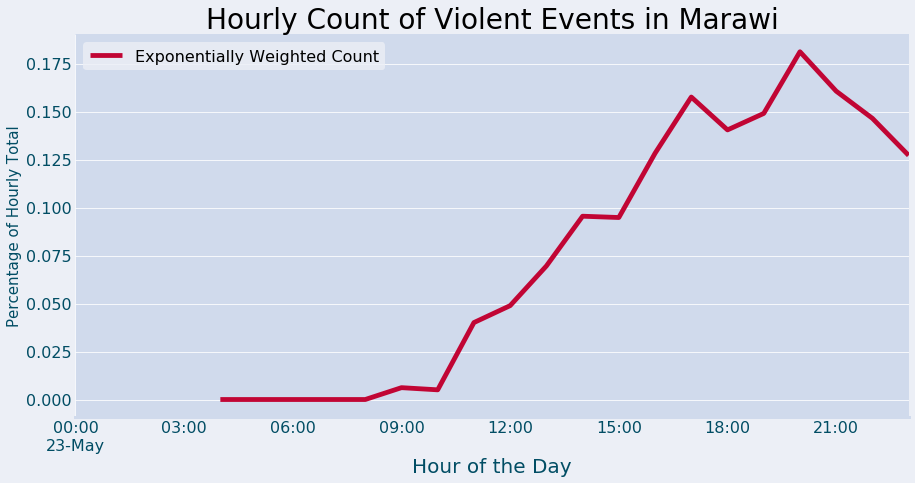

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.style.use('economist')
timeseries= pd.concat([marawi.resample('H')['sourceurl'].count(),maute2.resample('H')['sourceurl'].count()]
         ,axis=1)
timeseries.fillna(0,inplace=True)
timeseries.columns = ['Total Events','Marawi Violent Events Only']
timeseries = timeseries\
.assign(Normalized=(timeseries['Marawi Violent Events Only']/timeseries['Total Events'])*100)
f,ax = plt.subplots(figsize=(13,7))
ax = timeseries.Normalized\
.ewm(adjust=True,ignore_na=True,min_periods=5,span=12).mean()\
.plot(color="#C10534",label='Exponentially Weighted Count', linewidth=4.8)
ax.set_title('Hourly Count of Violent Events in Marawi',fontsize=28)
for label in ax.get_xticklabels():
      label.set_fontsize(16)
ax.set_xlabel('Hour of the Day', fontsize=20)
ax.set_ylabel('Percentage of Hourly Total',fontsize='15')
ax.legend()
plt.tight_layout()
plt.savefig('../assets/img/countGraphic.png')
# pd.date_range(start='2017 23 May 00:00:00', end='2017 23 May 23:59:59',freq='1H')

In [39]:
maute2= marawi[(marawi.actiongeofeatureid=='-2438515') \
               & (marawi.eventrootcode=='19')]

In [45]:
maute2.sourceurl.shape

(206,)

In [46]:
marawi.shape

(211911, 65)

In [44]:
maute2.drop_duplicates('sourceurl',keep='first').sort_values('dates',ascending=True)['sourceurl'].values.shape

(79,)

In [182]:
# Author: Linwood Creekmore
# Email: valinvescap@gmail.com
# Description:  Python script to pull content from a website (works on news stories).

###################################
# Standard Library imports
###################################

import re
from io import BytesIO

###################################
# Third party imports
###################################

import requests
import numpy as np
from bs4 import BeautifulSoup

done ={}
def textgetter(url):
    """Scrapes web news and returns the content
    
    Parameters
    ----------
    
    url : str
        Address to news report
        
    newstext: str
        Returns all text in the "p" tag.  This usually is the content of the news story.
    """
    global done
    
    # regex for url check
    s = re.compile('(http://|https://)([A-Za-z0-9_\.-]+)')
    
    # check that its an url
    if s.search(url):
        if url in done.keys():
            return done[url]
            pass
        else:

            r  = requests.get(url)
            if r.status_code != 200:
                done[url]="Unable to reach website."
                return {url:"Unable to reach website."}

            data = r.content

            soup = BeautifulSoup(data,'html.parser')

            newstext = " ".join([l.text for l in soup.find_all('p')])
            done[url]=newstext
            del r
            if len(newstext)>200:
                return {url:newstext}
            else:
                newstext = " ".join([l.text for l in soup.find_all('div',class_='field-item even')])
                done[url]=newstext
                if len(newstext)>200:
                    return {url:newstext}
                else:
                    return {url: "No text returned"}
    else:
        return {url:"This is not a proper url."}

In [47]:
maute2.actor2name.unique()

array([nan, 'VILLAGE', 'GUNMEN', 'ARMY', 'POLICE FORCE', 'RESIDENTS',
       'PHILIPPINE', 'CITIZEN', 'AMERICAN', 'INFANTRY', 'SPOKESMAN',
       'REBEL GROUP', 'TROOPER', 'GOVERNMENT FORCES', 'GOVERNMENT',
       'MILITARY', 'CALOOCAN', 'POLICEMAN', 'POLICE', 'ISLAMIC',
       'HOSPITAL', 'GOVERNMENT TROOPS AND POLICE', 'MILITANT', 'SCHOOL',
       'FIGHTER', 'GOVERNMENT TROOPS', 'REUTERS', 'MINDANAO', 'MANILA',
       'PRESIDENT', 'INSURGENT', 'POLICE OFFICER', 'SOUTHEAST ASIA',
       'TERRORIST', 'ARMED GROUP', 'MUSLIM', 'ABU SAYYAF', 'MILITARY RULE',
       'NANTES', 'POLICEMEN', 'MANCHESTER', 'SYRIA', 'DAMASCUS',
       'EXTREMIST', 'MOSCOW', 'ISNILON'], dtype=object)

In [183]:
urls = frame2['sourceurl'].unique()

In [184]:
d=maute2.sourceurl.drop_duplicates().values

In [191]:
from concurrent.futures import ProcessPoolExecutor

e = ProcessPoolExecutor()
%time results = list(e.map(textgetter,urls))
# %time results2 = np.array(list(e.map(textgetter,d)))
# done = {}
# %time results3 = marawi.sourceurl.drop_duplicates()[1240:1245].apply(textgetter).values
# %time results3 = marawi.sourceurl.drop_duplicates()[1240:1245].apply(textgetter).values

CPU times: user 52.8 ms, sys: 42.1 ms, total: 94.9 ms
Wall time: 40.4 s


In [187]:
sers = []

for l in results:
    ul = list(l.keys())[0]
    content = l[ul]
    sers.append(pd.Series({'url':ul,'content':content}))
connie = pd.concat(sers,axis=1).T

In [220]:
maute2 = maute2.merge(connie,left_on='sourceurl',right_on='url')

In [227]:
for l in maute2.drop_duplicates('sourceurl').sort_values('dates',ascending=True).content.values:
    print (l)

LANAO DEL SUR, Philippines - Gunshots reverberated through villages in Barangay Basak Malulut in Marawi City as Maute gunmen and soldiers clashed there Tuesday, sending Maranaws running for their lives. Senior Superintendent Oscar Nantes, director of the Lanao del Sur provincial police, said the scene of the encounter is not too distant from their headquarters and the campus of the Mindanao State University. “We can hear automatic gunshots from where we are,” Nantes told The STAR at exactly 3:20 p.m. Tuesday. Local officials told The STAR loud explosions rocked the barangay as members of the Maute terror group and soldiers traded shots. The Maute group is also known as the Dawlah Islamiya Philippines, which espouses hatred to non-Muslims. It also boasts of loyalty to the Islamic State of Iraq and Syria and uses the black ISIS flag as its revolutionary banner. Nantes said personnel of Army units under the 103rd Brigade based in Marawi City were to search for members of the Maute group i

In [72]:
rellie

2017-05-23 00:15:00    \n\n \n\r\n                        By Jen Krau...
2017-05-23 00:15:00    By\n\nJohn Stevens Deputy Political Editor For...
2017-05-23 00:15:00    Getting involved in your child’s school life i...
2017-05-23 00:15:00     Nationals Party delegates at Broken Hill on S...
2017-05-23 00:15:00    \n\tMORE sources have come forward to discredi...
2017-05-23 00:15:00    With a diamond ring in his pocket, Robert Paul...
2017-05-23 00:15:00    Almost two months later Mr Smith is still on v...
2017-05-23 00:15:00    A taskforce has been formed to ensure that key...
2017-05-23 00:15:00                             Unable to reach website.
2017-05-23 00:15:00    You currently have: Go to the Subscriptions Ce...
Name: sourceurl, dtype: object

In [41]:
rellie = marawi.sourceurl.drop_duplicates()[20:30].apply(textgetter)

In [307]:
b = pd.concat([d,maute2.sourceurl.drop_duplicates()],axis=1)
b.columns= ['content','url']
b[b.content=="Unable to reach website."]['url'].values

array([ 'http://www.sfgate.com/news/world/article/Philippine-troops-battle-IS-linked-gunmen-in-11166318.php',
       'http://www.channelnewsasia.com/news/asiapacific/philippine-forces-hunt-top-is-linked-militant-8876350',
       'http://www.nydailynews.com/newswires/news/world/philippine-troops-battle-is-linked-gunmen-southern-city-article-1.3188344',
       'https://newsinfo.inquirer.net/898775/govt-troops-clash-with-abus-maute-in-marawi-city',
       'http://www.huffingtonpost.co.uk/entry/islamic-state-linked-militants-take-over-hospital-and-set-jail-and-school-on-fire-in-philippines_uk_5924381ae4b034684b0fd280',
       'http://www.dnaindia.com/world/report-philippine-president-declares-martial-law-in-mindanao-spokesman-2448632',
       'http://www.channelnewsasia.com/news/world/philippine-president-declares-martial-law-in-mindanao---spokesman-8876894',
       'http://newsok.com/isis-linked-gunmen-battle-soldiers-in-streets-after-storming-philippines-city/article/5550227',
       'ht

In [256]:
len(done.keys())

6

In [222]:
d

2017-05-23 11:45:00                                     No text returned
2017-05-23 11:30:00    View the discussion thread.  Unit 909-910 Infi...
2017-05-23 11:30:00    View the discussion thread.  Unit 909-910 Infi...
2017-05-23 11:30:00    View the discussion thread.  Unit 909-910 Infi...
2017-05-23 11:30:00    View the discussion thread.  Unit 909-910 Infi...
2017-05-23 12:15:00    Martin Petty and Manuel Mogato 4 Min Read MANI...
2017-05-23 12:15:00    Martin Petty and Manuel Mogato 4 Min Read MANI...
2017-05-23 12:15:00      Security analysts say Isnilon Hapilon, a lea...
2017-05-23 12:15:00    \n  \n \n\n \n\n \n\n \n \n\n\n \n \n \n  \n  ...
2017-05-23 12:15:00    \n  \n \n\n \n\n \n\n \n \n\n\n \n \n \n  \n  ...
Name: sourceurl, dtype: object

In [166]:
ur = 'http://www.philstar.com/nation/2017/05/23/1702882/marawi-residents-told-stay-home-firefights-continue'
page = requests.get(ur)
soup = BeautifulSoup(page.content,'html.parser')

In [168]:
" ".join([l.text for l in soup.find_all('div',class_='field-item even')])                

' Marawi is the gateway to Lanao del Sur, a component province of the Autonomous Region in Muslim Mindanao. Philstar.com/John Unson, file \n\tLANAO DEL SUR, Philippines \xa0— \xa0Officials on Tuesday urged Marawi City residents to stay home as firefights continued on city streets between Maute terrorists and soldiers.\n\n\t\xa0\n\n\tLanao del Sur Vice Gov. Mamintal Adiong, Jr., a senior member of the provincial peace and order council, also called on Marawi City residents to be extra vigilant and prevent strangers from intruding into their property.\n\n\t\xa0\n\n\t“I’m appealing to residents of Marawi City to stay home, drop on the ground if they hear gunshots. They have to lock their doors and gates too,” Adiong told The STAR via mobile phone on Tuesday afternoon.\n\n\t\xa0\n\n\tShooting between Islamic militants and personnel of the Army’s 103rd Infantry Brigade in Marawi City started at about 3:00 p.m. Tuesday, sending residents running for safety.\n\n\t\xa0\n\n\tSenior officials of

In [234]:
" ".join([l.text for l in soup.find_all('div',class_='field-item even')])
# soup.find_all('p', class_='outer-text')

' Marawi is the gateway to Lanao del Sur, a component province of the Autonomous Region in Muslim Mindanao. Philstar.com/John Unson, file \n\tLANAO DEL SUR, Philippines \xa0— \xa0Officials on Tuesday urged Marawi City residents to stay home as firefights continued on city streets between Maute terrorists and soldiers.\n\n\t\xa0\n\n\tLanao del Sur Vice Gov. Mamintal Adiong, Jr., a senior member of the provincial peace and order council, also called on Marawi City residents to be extra vigilant and prevent strangers from intruding into their property.\n\n\t\xa0\n\n\t“I’m appealing to residents of Marawi City to stay home, drop on the ground if they hear gunshots. They have to lock their doors and gates too,” Adiong told The STAR via mobile phone on Tuesday afternoon.\n\n\t\xa0\n\n\tShooting between Islamic militants and personnel of the Army’s 103rd Infantry Brigade in Marawi City started at about 3:00 p.m. Tuesday, sending residents running for safety.\n\n\t\xa0\n\n\tSenior officials of

In [ ]:
mautesub[['sourceurl','dateadded','datezone']].drop_duplicates('sourceurl').sort_values('datezone',ascending=True).values

In [37]:
# print(maute2.sort_values('datezone')[['datezone','sourceurl']].drop_duplicates('sourceurl').head().to_html())

In [ ]:
holder = margkg['date'][margkg['date'].notnull()==True].index
margkg=margkg.assign(datefix=margkg['date'])
margkg['datefix'].loc[holder]=vect(margkg['date'].values[holder])
print(margkg['datefix'][margkg['datefix'].notnull()==False])
margkg['datefix']=margkg['datefix'].fillna(method='pad')

In [ ]:
samp = datframe.sample(samplenum)
ax = gplt.polyplot(polyframe,projection=gcrs.PlateCarree(),figsize=(20,12))
gplt.kdeplot(samp,ax=ax,shade=True,shade_lowest=False,projection=gcrs.TransverseMercator())